# Predicting Telco Customer Churn

The goal of this project was to build a classification model that predicts which telecommunications customers are likely to cancel their service. I trained and compared three models—KNN, Random Forest, and Gradient Boosting—then tuned the best performers to maximize predictive accuracy.

The final model achieves a ROC-AUC of 0.865, with tenure and contract type emerging as the strongest predictors of churn.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve, precision_score, recall_score, f1_score)
from sklearn.model_selection import cross_val_score, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)


## Data

I preprocessed the data in a separate notebook—handling missing values in TotalCharges, encoding categorical variables, and scaling numeric features. The data was split 80/20 for training and testing.


In [3]:
X_train = pd.read_csv('./X_train.csv')
y_train = pd.read_csv('./y_train.csv').squeeze()
X_test = pd.read_csv('./X_test.csv')
y_test = pd.read_csv('./y_test.csv').squeeze()

X_train.shape, X_test.shape


((5634, 30), (1409, 30))

In [4]:
# ~27% churn rate means the classes are imbalanced
y_train.value_counts(normalize=True)


Churn
0    0.734469
1    0.265531
Name: proportion, dtype: float64

In [5]:
X_train.columns.tolist()


['SeniorCitizen',
 'tenure',
 'MonthlyCharges',
 'TotalCharges',
 'gender_Male',
 'Partner_Yes',
 'Dependents_Yes',
 'PhoneService_Yes',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'InternetService_Fiber optic',
 'InternetService_No',
 'OnlineSecurity_No internet service',
 'OnlineSecurity_Yes',
 'OnlineBackup_No internet service',
 'OnlineBackup_Yes',
 'DeviceProtection_No internet service',
 'DeviceProtection_Yes',
 'TechSupport_No internet service',
 'TechSupport_Yes',
 'StreamingTV_No internet service',
 'StreamingTV_Yes',
 'StreamingMovies_No internet service',
 'StreamingMovies_Yes',
 'Contract_One year',
 'Contract_Two year',
 'PaperlessBilling_Yes',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check']

## Model Training

I chose to compare KNN as a simple baseline against two ensemble methods. Given the tabular nature of this data and the mix of categorical/numeric features, I expected tree-based models to perform well.


### KNN


In [6]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)
y_prob_knn = knn_model.predict_proba(X_test)[:, 1]



### Random Forest


In [7]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]


### Gradient Boosting


In [8]:
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)
y_prob_gb = gb_model.predict_proba(X_test)[:, 1]


## Evaluation

For churn prediction, I prioritized recall and ROC-AUC. Missing a customer who will churn is more costly than a false alarm—we can offer retention incentives either way, but we can't save customers we never identified.


### KNN: Decent baseline but nothing special


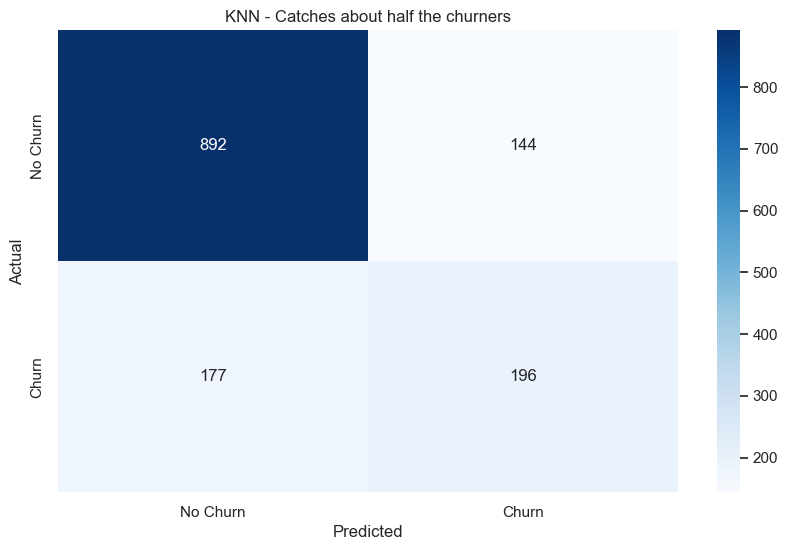

In [9]:
cm = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title('KNN - Catches about half the churners')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


### Random Forest: High precision but misses too many churners


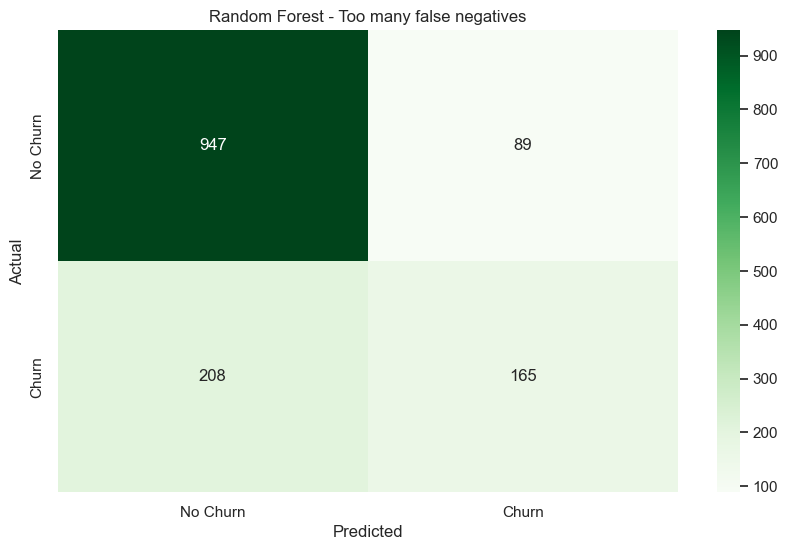

In [10]:
# RF is conservative—low false positives but 208 missed churners is a problem
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title('Random Forest - Too many false negatives')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


### Gradient Boosting: Best balance so far


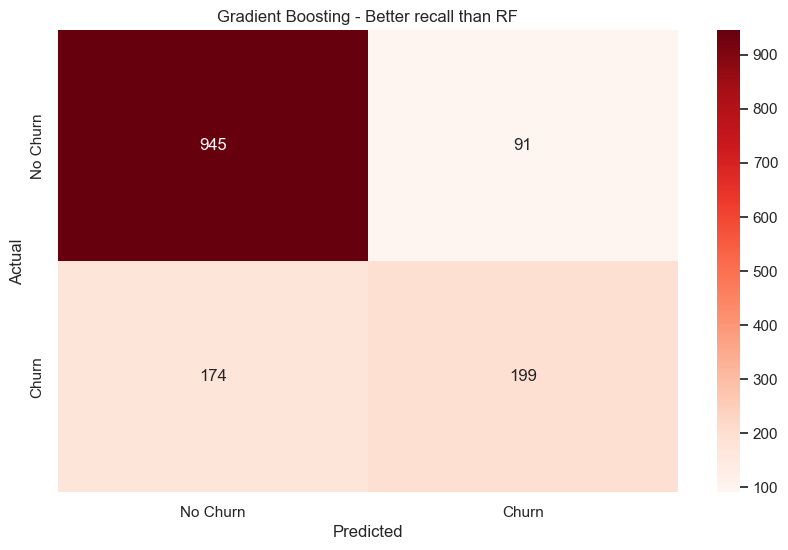

In [11]:
# GB catches more churners while keeping false positives reasonable
cm = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title('Gradient Boosting - Better recall than RF')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


### Performance Metrics


In [12]:
def calculate_metrics(y_true, y_pred, y_prob, model_name):
    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_prob)
    }

knn_metrics = calculate_metrics(y_test, y_pred_knn, y_prob_knn, 'KNN')
rf_metrics = calculate_metrics(y_test, y_pred_rf, y_prob_rf, 'Random Forest')
gb_metrics = calculate_metrics(y_test, y_pred_gb, y_prob_gb, 'Gradient Boosting')

results_df = pd.DataFrame([knn_metrics, rf_metrics, gb_metrics]).set_index('Model')
results_df.round(4)


,Accuracy,Precision,Recall,F1 Score,ROC-AUC
Model,,,,,
KNN,0.7722,0.5765,0.5255,0.5498,0.7970
Random Forest,0.7892,0.6496,0.4424,0.5263,0.8358
Gradient Boosting,0.8119,0.6862,0.5335,0.6003,0.8630


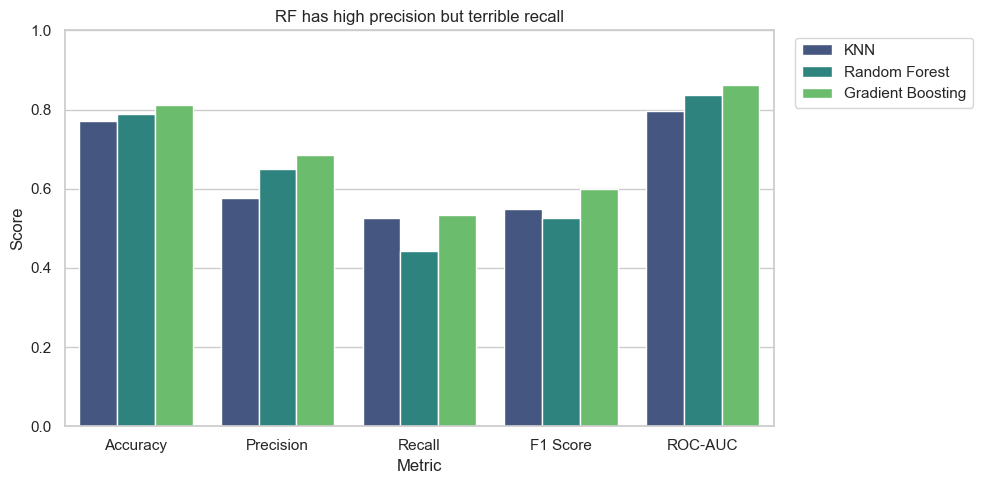

In [13]:
# GB wins on most metrics, but RF's recall is concerning
plot_melted = results_df.reset_index().melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 5))
ax = sns.barplot(data=plot_melted, x='Metric', y='Score', hue='Model', palette='viridis')
plt.ylim(0, 1)
plt.title('RF has high precision but terrible recall')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


### ROC Curves


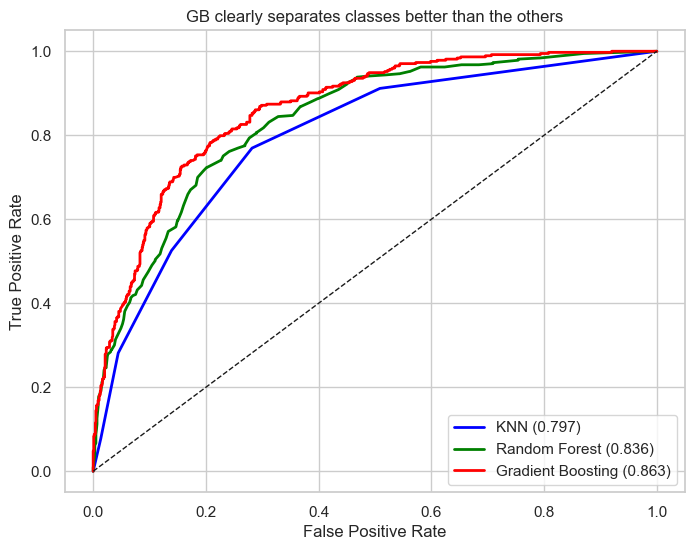

In [14]:
# ROC-AUC is my main metric since it captures ranking ability across all thresholds
plt.figure(figsize=(8, 6))

for name, (y_prob, color) in [('KNN', (y_prob_knn, 'blue')), 
                               ('Random Forest', (y_prob_rf, 'green')),
                               ('Gradient Boosting', (y_prob_gb, 'red'))]:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, color=color, linewidth=2, label=f'{name} ({auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('GB clearly separates classes better than the others')
plt.legend(loc='lower right')
plt.show()


### Cross-Validation

I ran 5-fold CV to check that these results weren't just due to a lucky train/test split.


In [15]:
cv_knn = cross_val_score(knn_model, X_train, y_train, cv=5, scoring='roc_auc')
cv_rf = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='roc_auc')
cv_gb = cross_val_score(gb_model, X_train, y_train, cv=5, scoring='roc_auc')

cv_results = pd.DataFrame({
    'Model': ['KNN', 'Random Forest', 'Gradient Boosting'],
    'CV Mean': [cv_knn.mean(), cv_rf.mean(), cv_gb.mean()],
    'CV Std': [cv_knn.std(), cv_rf.std(), cv_gb.std()]
}).set_index('Model')

cv_results.round(4)


,CV Mean,CV Std
Model,,
KNN,0.7829,0.0082
Random Forest,0.8227,0.0124
Gradient Boosting,0.8418,0.0106


## Hyperparameter Tuning

Gradient Boosting showed the best baseline performance, but I tuned both ensemble models to see if I could close the gap or improve further.


### Random Forest


In [16]:
# RF had terrible recall—trying max_depth limits to reduce overfitting
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid,
                               cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
rf_grid_search.fit(X_train, y_train)

rf_grid_search.best_params_, rf_grid_search.best_score_


Fitting 5 folds for each of 24 candidates, totalling 120 fits


({'max_depth': 10,
  'min_samples_leaf': 2,
  'min_samples_split': 5,
  'n_estimators': 200},
 0.8396220384710041)

### Gradient Boosting


In [25]:
# GB already performed well, but maybe a lower learning rate with more trees helps
gb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

gb_grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_param_grid,
                               cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
gb_grid_search.fit(X_train, y_train)

gb_grid_search.best_params_, gb_grid_search.best_score_


Fitting 5 folds for each of 36 candidates, totalling 180 fits


({'learning_rate': 0.05,
  'max_depth': 3,
  'n_estimators': 100,
  'subsample': 0.8},
 0.8436773977503126)

### Tuned Model Comparison


In [26]:
rf_tuned = rf_grid_search.best_estimator_
gb_tuned = gb_grid_search.best_estimator_

y_pred_rf_tuned = rf_tuned.predict(X_test)
y_prob_rf_tuned = rf_tuned.predict_proba(X_test)[:, 1]
y_pred_gb_tuned = gb_tuned.predict(X_test)
y_prob_gb_tuned = gb_tuned.predict_proba(X_test)[:, 1]

rf_tuned_metrics = calculate_metrics(y_test, y_pred_rf_tuned, y_prob_rf_tuned, 'Random Forest (Tuned)')
gb_tuned_metrics = calculate_metrics(y_test, y_pred_gb_tuned, y_prob_gb_tuned, 'Gradient Boosting (Tuned)')

comparison_df = pd.DataFrame([knn_metrics, rf_metrics, rf_tuned_metrics, 
                               gb_metrics, gb_tuned_metrics]).set_index('Model')
comparison_df.round(4)


,Accuracy,Precision,Recall,F1 Score,ROC-AUC
Model,,,,,
KNN,0.7722,0.5765,0.5255,0.5498,0.7970
Random Forest,0.7892,0.6496,0.4424,0.5263,0.8358
Random Forest (Tuned),0.8169,0.7076,0.5255,0.6031,0.8632
Gradient Boosting,0.8119,0.6862,0.5335,0.6003,0.8630
Gradient Boosting (Tuned),0.8148,0.6972,0.5308,0.6027,0.8654


## Feature Importance

### RF spreads importance across many features


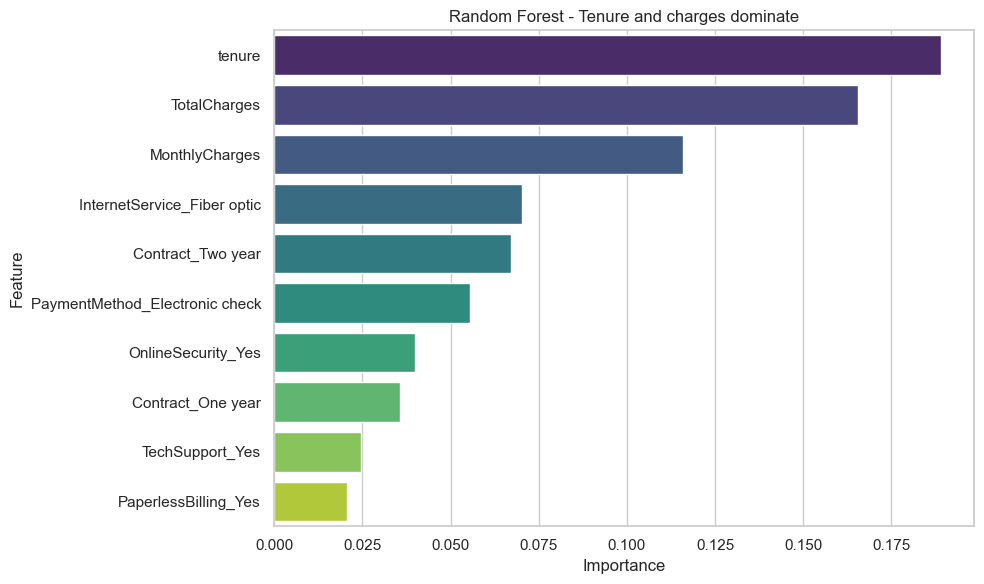

In [27]:
rf_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf_tuned.feature_importances_}
                             ).sort_values('Importance', ascending=False)

# RF uses tenure/charges but also pays attention to service add-ons
sns.barplot(data=rf_importance.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('Random Forest - Tenure and charges dominate')
plt.tight_layout()
plt.show()


### GB puts almost all weight on tenure and fiber optic


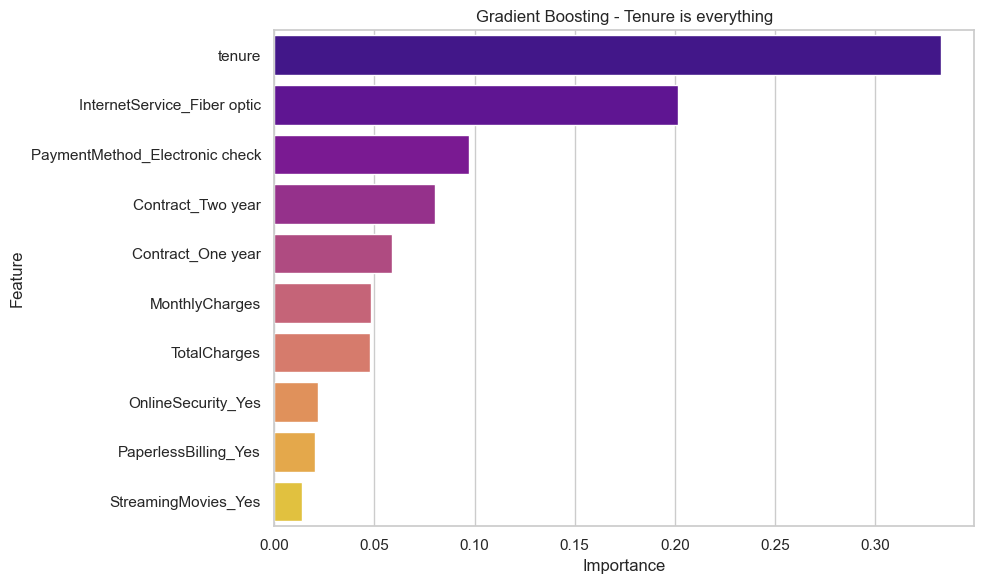

In [28]:
gb_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': gb_tuned.feature_importances_}
                             ).sort_values('Importance', ascending=False)

# GB is more aggressive—tenure alone accounts for 33% of importance
sns.barplot(data=gb_importance.head(10), x='Importance', y='Feature', palette='plasma')
plt.title('Gradient Boosting - Tenure is everything')
plt.tight_layout()
plt.show()


In [29]:
# Both models agree on most key features, just weight them differently
common = set(rf_importance.head(10)['Feature']) & set(gb_importance.head(10)['Feature'])
sorted(common)


['Contract_One year',
 'Contract_Two year',
 'InternetService_Fiber optic',
 'MonthlyCharges',
 'OnlineSecurity_Yes',
 'PaperlessBilling_Yes',
 'PaymentMethod_Electronic check',
 'TotalCharges',
 'tenure']

## Conclusions


In [30]:
final_comparison = pd.DataFrame([knn_metrics, rf_tuned_metrics, gb_tuned_metrics]).set_index('Model')
final_comparison.round(4)


,Accuracy,Precision,Recall,F1 Score,ROC-AUC
Model,,,,,
KNN,0.7722,0.5765,0.5255,0.5498,0.7970
Random Forest (Tuned),0.8169,0.7076,0.5255,0.6031,0.8632
Gradient Boosting (Tuned),0.8148,0.6972,0.5308,0.6027,0.8654


Gradient Boosting (Tuned) achieved the best ROC-AUC (0.865) and highest recall, making it my recommended model. The ensemble methods clearly outperformed KNN on this tabular dataset.

The most predictive features were tenure, contract type, and internet service type. Customers on month-to-month contracts with fiber optic internet showed the highest churn risk, especially those who pay via electronic check. This suggests retention efforts should prioritize new customers and those without longer-term contracts.

Tuning improved Random Forest significantly (+2.7% ROC-AUC) while Gradient Boosting saw only marginal gains, indicating its default parameters were already well-suited to this problem.

In [31]:
# 53% recall on churners isn't great
print(classification_report(y_test, y_pred_gb_tuned, target_names=['No Churn', 'Churn']))


              precision    recall  f1-score   support

    No Churn       0.84      0.92      0.88      1036
       Churn       0.70      0.53      0.60       373

    accuracy                           0.81      1409
   macro avg       0.77      0.72      0.74      1409
weighted avg       0.81      0.81      0.81      1409

